In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Thesis/EI-main/')
!pwd

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Thesis/EI-main


In [4]:
from typing import NamedTuple
class otherParametersStruct_t3(NamedTuple):
    gpu: int
    dataset_name: str
    sample_to_show: None
    ckp: str
    model_name: str

In [5]:
import torch

from models.unet import UNet
from dataset.ctdb import CTData
from physics.ct import CT
from utils.metric import cal_psnr

import argparse
import matplotlib.pyplot as plt

def main():
    # args = parser.parse_args()
    args = otherParametersStruct_t3(
        0,
        'Urban100',
        [9],
        './ckp/ct/ckp_ei_adv_final.pth.tar',
        'EI')

    device = f'cuda:{args.gpu}'

    unet = UNet(in_channels=1, out_channels=1, compact=4, residual=True,
                circular_padding=True, cat=True).to(device)
    forw = CT(img_width=128, radon_view=50, circle=False, device=device)
    dataloader = torch.utils.data.DataLoader(dataset=CTData(mode='test'),batch_size=1, shuffle=False)

    def test(net, ckp, fbp, adv=False):
        checkpoint = torch.load(ckp, map_location=device)
        net.load_state_dict(checkpoint['state_dict_G' if adv else 'state_dict'])
        net.to(device).eval()
        return net(fbp)

    for i, x in enumerate(dataloader):
        if i in args.sample_to_show:
            if len(x.shape) == 3:
                x = x.unsqueeze(1)
            x = x.type(torch.float).to(device)

            y = forw.A(x)
            fbp = forw.A_dagger(y)
            x_hat = test(unet, args.ckp, fbp, adv=True)

            plt.subplot(1,4,1)
            plt.imshow(y[0].detach().permute(1, 2, 0).cpu().numpy().squeeze())
            plt.title('y')
            
            plt.subplot(1,4,2)
            plt.imshow(fbp[0].detach().permute(1, 2, 0).cpu().numpy().squeeze())
            plt.title('FBP ({:.2f})'.format(cal_psnr(x, fbp)))
            
            plt.subplot(1,4,3)
            plt.imshow(x_hat[0].detach().permute(1, 2, 0).cpu().numpy().squeeze())
            plt.title('{} ({:.2f})'.format(args.model_name, cal_psnr(x, x_hat)))
            
            plt.subplot(1,4,4)
            plt.imshow(x[0].detach().permute(1, 2, 0).cpu().numpy().squeeze())
            plt.title('x (GT)')
            
            ax = plt.gca()
            ax.set_xticks([]), ax.set_yticks([])
            plt.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9, hspace=0.02, wspace=0.02)
            plt.show()
        else:
            continue
main()


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TypeError: ignored

In [ ]:
import numpy as np
# f = torch.from_numpy(np.array([0., 1., 0., 0.]))
# print(torch.from_numpy(np.fft.rfft(f)))
# print(torch.rfft(f, 1, onesided=False))
# print(torch.rfft(f, 1, onesided=True))

f = torch.from_numpy(np.array([[[[[0.,1.], [1.,2.], [1.,2.], [2.,3.]],[[1.,0.],[2.,0.], [1.,2.], [2.,3.]],[[2.,1.],[3.,2.], [1.,2.], [2.,3.]]]]]))
print(f.shape)
result = torch.irfft(f.transpose(2,3), 1, onesided=False)
print(result)
print(result.shape)

torch.Size([1, 1, 3, 4, 2])
tensor([[[[ 0.6667, -0.3333, -0.3333],
          [ 1.6667, -0.3333, -0.3333],
          [ 1.0000, -1.1547,  1.1547],
          [ 2.0000, -1.7321,  1.7321]]]], dtype=torch.float64)
torch.Size([1, 1, 4, 3])


In [ ]:
import torch
print(torch.__version__)

1.12.0+cu102


In [ ]:
!pip install torch==1.7.1 torchvision==0.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 21.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
!pip install --upgrade torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.3 MB 19 kB/s 
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2


Urban100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


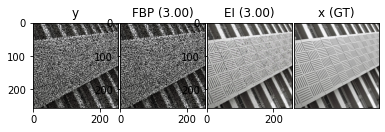

Inpainting (0.4) AVG-PSNR: A^+y=nan	EI=nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import torch
import numpy as np
from physics.inpainting import Inpainting
from dataset.cvdb import CVDB_ICCV
from models.unet import UNet
from utils.metric import cal_psnr

import argparse
import matplotlib.pyplot as plt

# parser = argparse.ArgumentParser(description='Inpainting test.')

# parser.add_argument('--gpu', default=0, type=int, help='GPU id to use.')
# parser.add_argument('--dataset-name', default='Urban100', type=str,
#                     help="dataset name=['Urban100'] (default: 'Urban100')."
#                          "You can add your test image set under ./dataset/")
# parser.add_argument('--sample-to-show', default=[0], nargs='*', type=int,
#                     help='the test sample id for visualization'
#                          'default [0]')
# # specifying path to trained models:
# parser.add_argument('--ckp', default='./ckp/inpainting/ckp_rei_ipt_poisson_gamma_5e-2.pth.tar', type=str, metavar='PATH',
#                     help='path to checkpoint of EI net')
# parser.add_argument('--model-name', default='EI', type=str, help="name of the trained model (dafault: 'EI')")

def main():
    # args = parser.parse_args()
    noise = 0.3
    args = otherParametersStruct_t3(
        0,
        'Urban100',
        [1],
        './ckp/inpainting/ckp_ei_adv_final.pth.tar',
        'EI')

    device = f'cuda:{args.gpu}'
    print(args.dataset_name)

    # define the dataloader (i.e. 'urban100', first 90 imgs for training, last 10 for testing)
    dataloader = CVDB_ICCV(dataset_name=args.dataset_name, mode='test', batch_size=1, shuffle=False)

    # define the forward oeprator (i.e. physics)
    forw = Inpainting(img_heigth=256, img_width=256, mask_rate=noise, device=device)

    # define the network G (i.e. residual unet in the paper)
    unet = UNet(in_channels=3, out_channels=3, compact=4, residual=True,
                circular_padding=True, cat=True).to(device)

    psnr_fbp, psnr_net=[],[]

    def test(net, ckp, fbp, adv=False):
        checkpoint = torch.load(ckp, map_location=device)
        net.load_state_dict(checkpoint['state_dict_G' if adv else 'state_dict'])
        net.to(device).eval()
        return net(fbp)

    for i, x in enumerate(dataloader):
        x = x[0] if isinstance(x, list) else x
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        # groundtruth
        x = x.type(torch.float).to(device)
        # compute measurement
        y = forw.A(x)
        # compute the A^+y or FBP
        fbp = forw.A_dagger(y)

        x_hat = test(unet, args.ckp, fbp, adv=True)

        if i in args.sample_to_show:
            plt.subplot(1,4,1)
            plt.imshow(y.squeeze().detach().permute(1, 2, 0).cpu().numpy())
            plt.title('y')
            
            plt.subplot(1,4,2)
            plt.imshow(fbp.squeeze().detach().permute(1, 2, 0).cpu().numpy())
            plt.title('FBP ({:.2f})'.format(cal_psnr(x, fbp)))
            
            plt.subplot(1,4,3)
            plt.imshow(x_hat.squeeze().detach().permute(1, 2, 0).cpu().numpy())
            plt.title('{} ({:.2f})'.format(args.model_name, cal_psnr(x, x_hat)))
            
            plt.subplot(1,4,4)
            plt.imshow(x.squeeze().detach().permute(1, 2, 0).cpu().numpy())
            plt.title('x (GT)')
            
            ax = plt.gca()
            ax.set_xticks([]), ax.set_yticks([])
            plt.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9, hspace=0.02, wspace=0.02)
            plt.show()
            
    print('Inpainting ({:.1f}) AVG-PSNR: A^+y={:.2f}\t{}={:.2f}'.format(noise, np.mean(psnr_fbp), args.model_name, np.mean(psnr_net)))


main()
